# For training in cmd

In [ ]:
#python MY_VOLUME/keras-retinanet-0.5.0/keras-retinanet-0.5.0/train.py csv keras_retinanet/train_labels.csv keras_retinanet/class_mapping.csv
#python MY_VOLUME/keras-retinanet-0.5.0/keras-retinanet-0.5.0/train.py csv MY_VOLUME/keras-retinanet-0.5.0/keras-retinanet-0.5.0/keras_retinanet/train_labels.csv MY_VOLUME/keras-retinanet-0.5.0/keras-retinanet-0.5.0/keras_retinanet/class_mapping.csv

# Filtering

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc
import numpy as np

import mcubes

from subprocess import check_output
import os

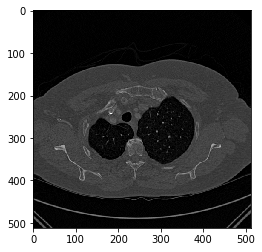

In [ ]:
lung = dicom.read_file('/notebooks/MY_VOLUME/keras-retinanet-0.5.0/keras-retinanet-0.5.0/_TrainingSet/CT-Training-BE001/01-03-2007-16904-CT INFUSED CHEST-143.1/4-HIGH RES-47.17/000000.dcm')

slice = lung.pixel_array
slice[slice == -2000] = 0
plt.imshow(slice, cmap=plt.cm.gray)

In [ ]:
def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        
        # Sort the dicom slices in their respective order
        slices.sort(key=lambda x: int(x.InstanceNumber))
        
        # Get the pixel values for all the slices
        slices = np.stack([s.pixel_array for s in slices])
        slices[slices == -2000] = 0
        return slices

In [ ]:
ct_scan = read_ct_scan('/notebooks/MY_VOLUME/keras-retinanet-0.5.0/keras-retinanet-0.5.0/_TrainingSet/CT-Training-BE001/01-03-2007-16904-CT INFUSED CHEST-143.1/4-HIGH RES-47.17/') 

In [ ]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.gray)

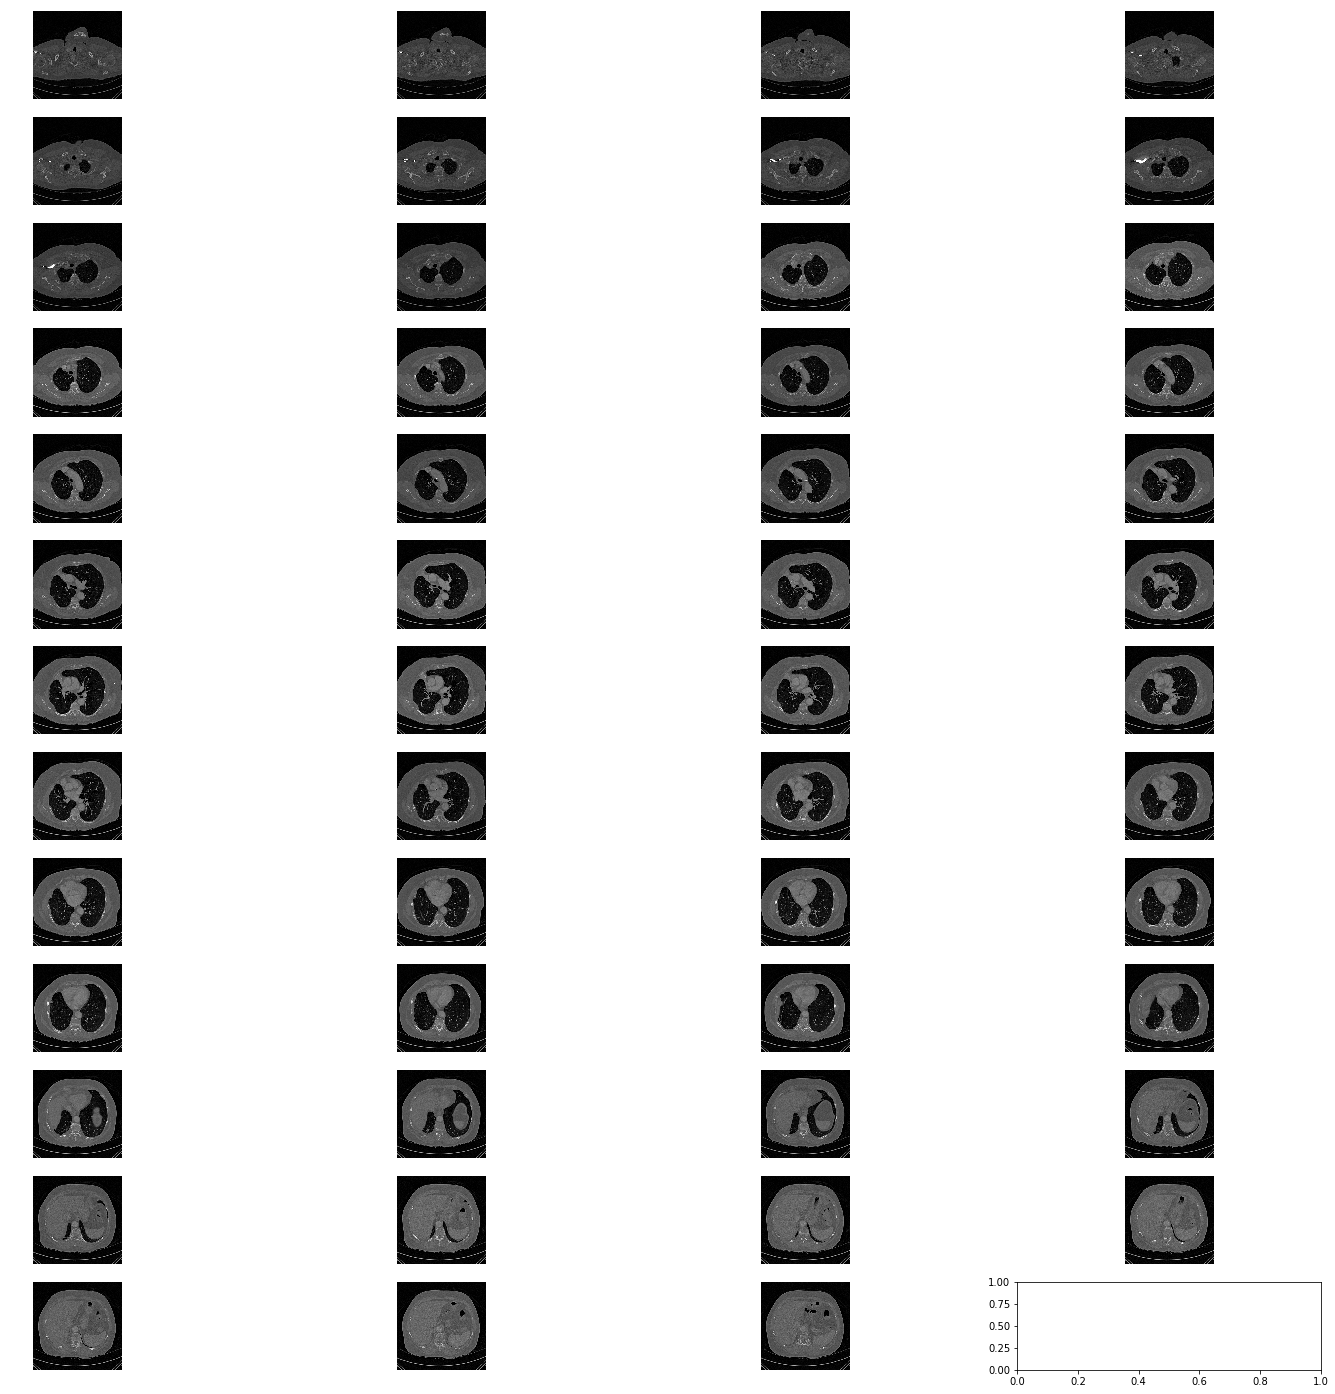

In [ ]:
plot_ct_scan(ct_scan)

In [ ]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 604
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

In [ ]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

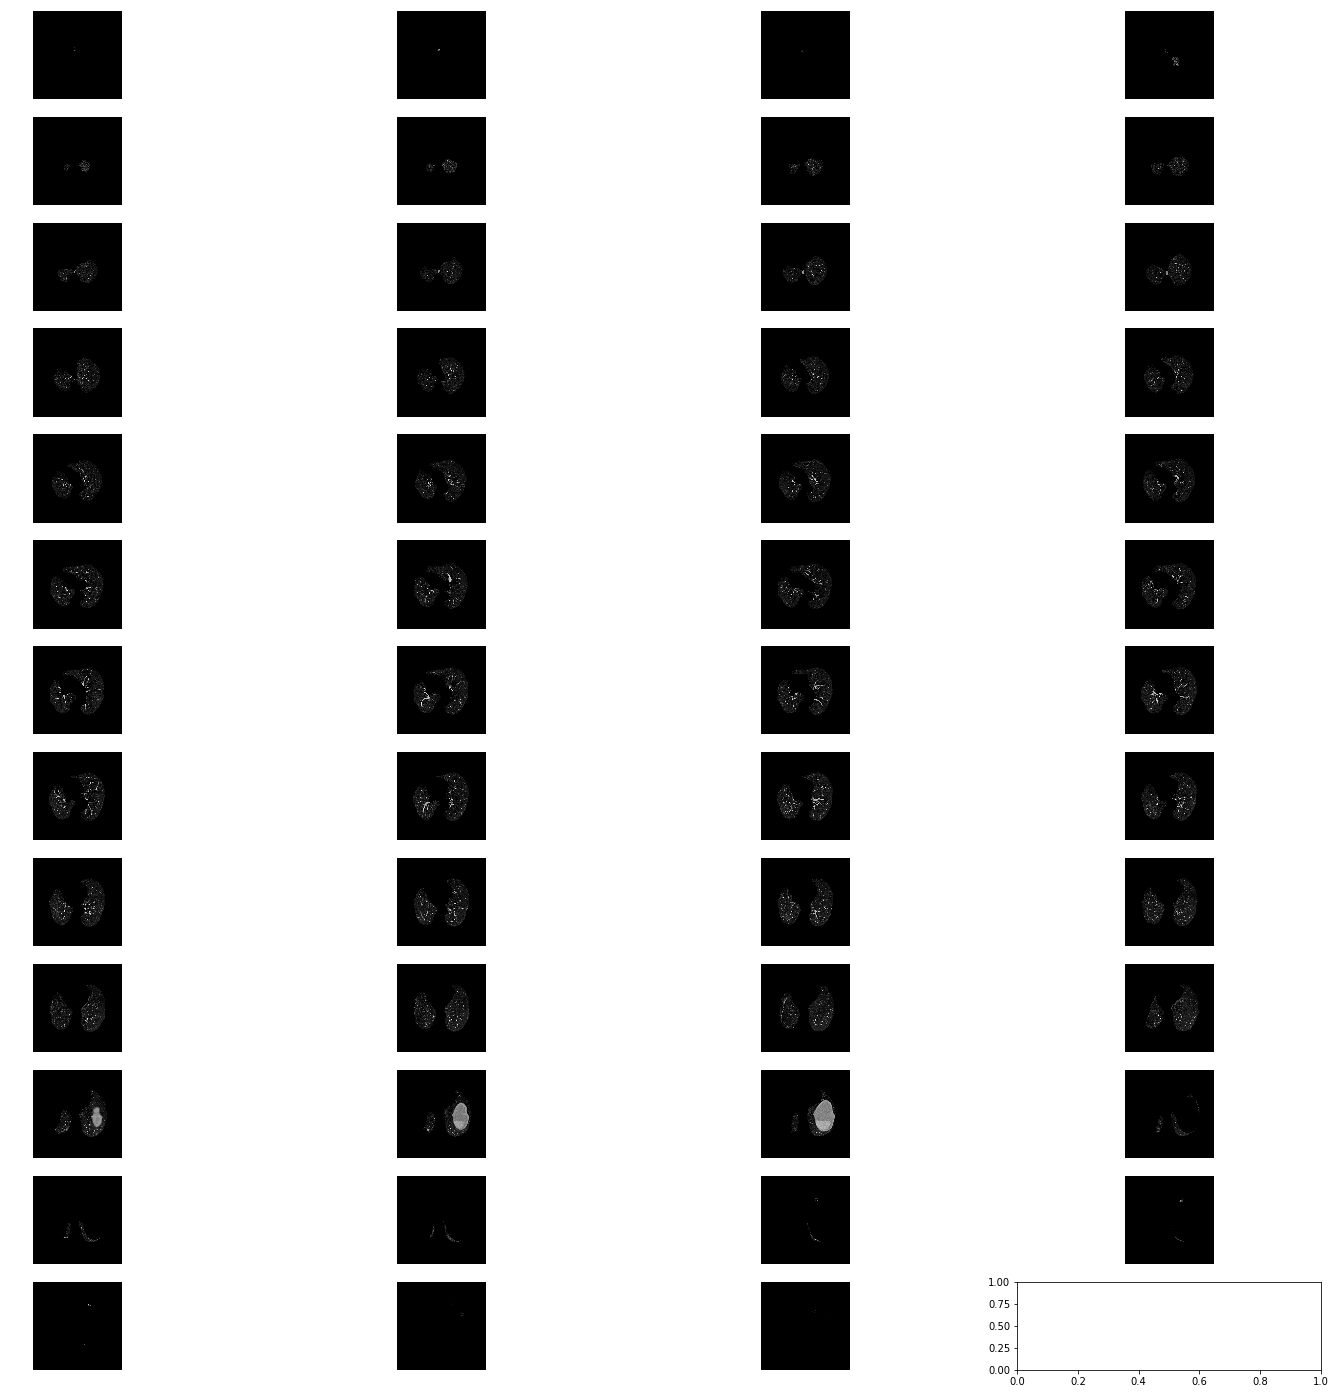

In [ ]:
segmented_ct_scan = segment_lung_from_ct_scan(ct_scan)
plot_ct_scan(segmented_ct_scan)

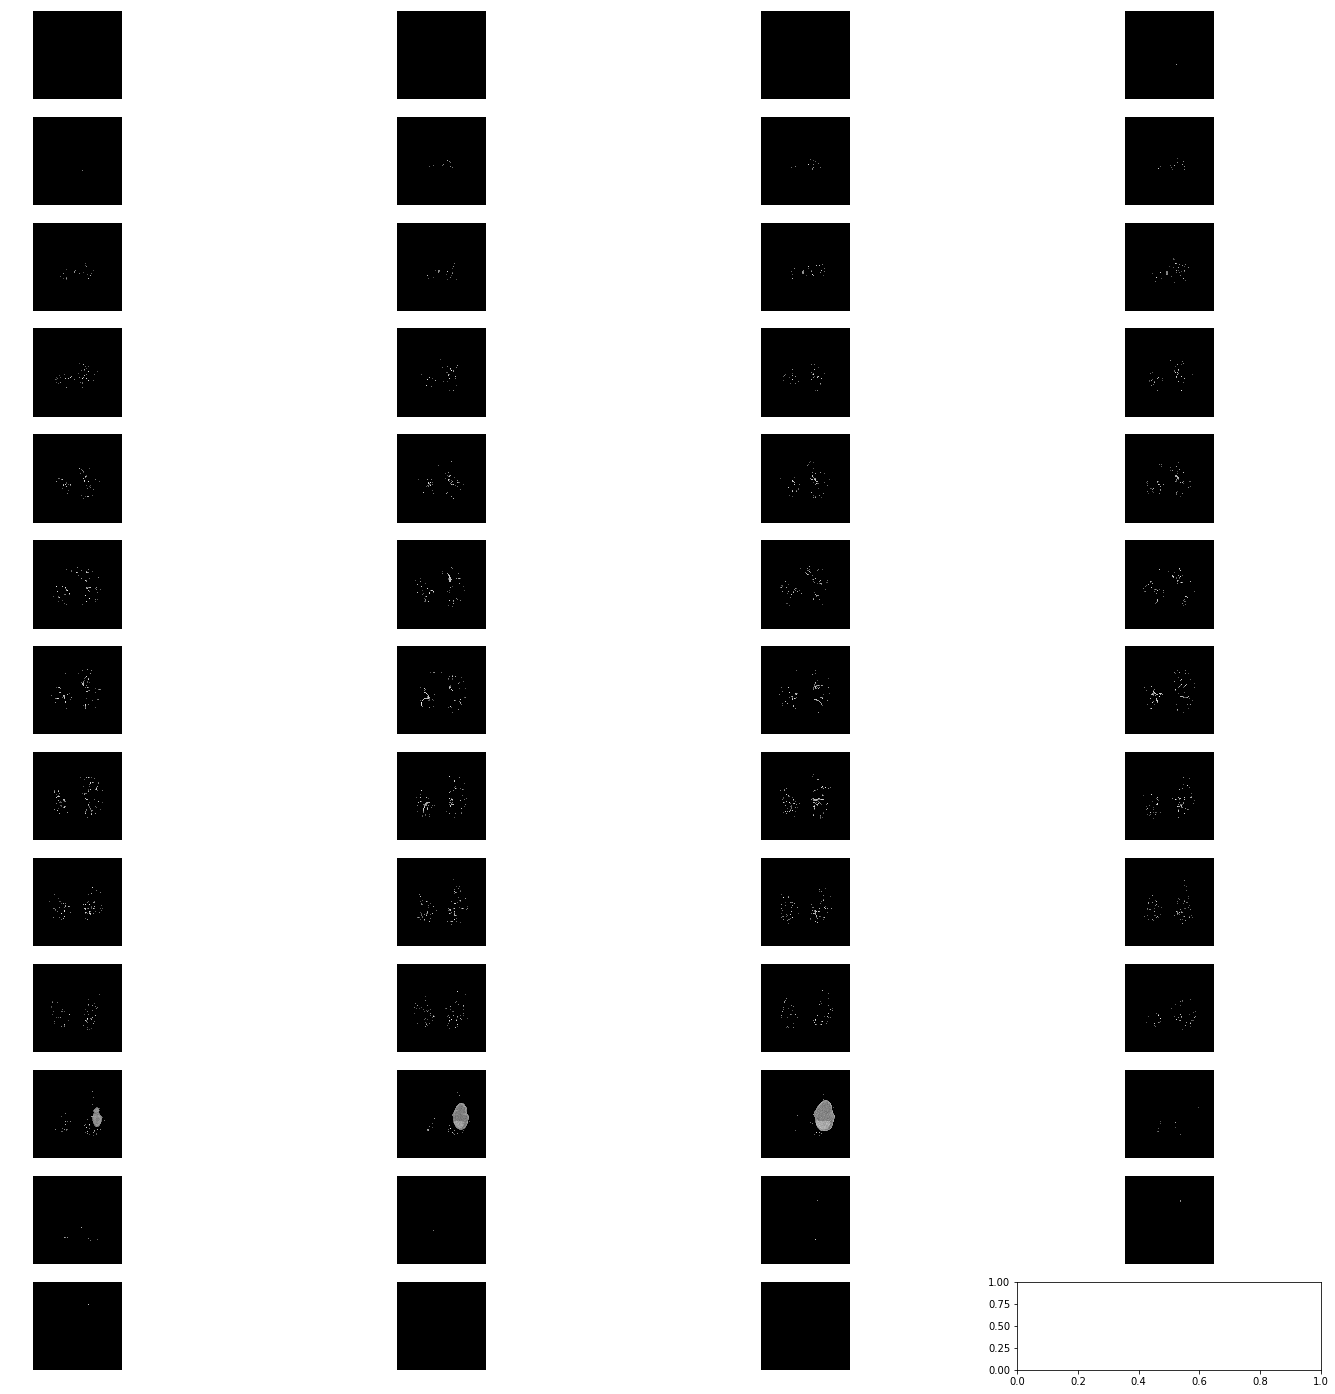

In [ ]:
segmented_ct_scan[segmented_ct_scan < 604] = 0
plot_ct_scan(segmented_ct_scan)

# Detection

In [ ]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os

import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf
import os

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [ ]:
# load retinanet model
model = keras_retinanet.models.load_model( '/notebooks/MY_VOLUME/keras-retinanet-0.5.0/keras-retinanet-0.5.0/resnet50_csv_50.h5',backbone_name='resnet50')

model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = {1:'nodule'}

In [ ]:
boxess = []
scoress = []
labelss = []
namess = []

In [ ]:
import numpy
import PIL
num_slices = len(segmented_ct_scan)
print(num_slices)

251


In [ ]:
for i in range(num_slices)  :
    # load image
    image = segmented_ct_scan[i]
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # preprocess image for network
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image_color = preprocess_image(image_color)
    image_color, scale = resize_image(image_color)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image_color, axis=0))
    print("processing time: ", time.time() - start)
    
    # correct for image scale
    boxes /= scale

   #keep only scores >=0.995
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score <= 0.995:
            break
        boxess.append(box)
        scoress.append(score)
        labelss.append(label)
        namess.append(i)

processing time:  3.401693820953369
processing time:  0.08222675323486328
processing time:  0.09023904800415039
processing time:  0.08192658424377441
processing time:  0.08241772651672363
processing time:  0.08237385749816895
processing time:  0.09017014503479004
processing time:  0.08049488067626953
processing time:  0.08275341987609863
processing time:  0.08184313774108887
processing time:  0.08922028541564941
processing time:  0.08520865440368652
processing time:  0.08239030838012695
processing time:  0.08259868621826172
processing time:  0.08226442337036133
processing time:  0.08204030990600586
processing time:  0.08266949653625488
processing time:  0.08215522766113281
processing time:  0.0822441577911377
processing time:  0.08212494850158691
processing time:  0.08192658424377441
processing time:  0.08252549171447754
processing time:  0.08224987983703613
processing time:  0.09114313125610352
processing time:  0.0819251537322998
processing time:  0.08249783515930176
processing time:

processing time:  0.0820012092590332
processing time:  0.08237981796264648
processing time:  0.08221006393432617
processing time:  0.08512759208679199
processing time:  0.08250999450683594
processing time:  0.08202910423278809
processing time:  0.08222794532775879
processing time:  0.08217382431030273
processing time:  0.08246088027954102
processing time:  0.08267068862915039
processing time:  0.08262395858764648
processing time:  0.08302640914916992
processing time:  0.08876776695251465
processing time:  0.08231568336486816
processing time:  0.08188009262084961
processing time:  0.08246898651123047
processing time:  0.08231258392333984
processing time:  0.08260822296142578
processing time:  0.09155654907226562
processing time:  0.08210253715515137
processing time:  0.0823221206665039
processing time:  0.08211326599121094
processing time:  0.08240103721618652
processing time:  0.0821681022644043
processing time:  0.08234572410583496
processing time:  0.08224916458129883
processing time

In [ ]:
z = zip(boxess,labelss,namess,scoress )
sorted_z = sorted(z, key=lambda x: x[3], reverse = True)
print(sorted_z)

[(array([133.20354, 277.1851 , 219.19943, 356.5902 ], dtype=float32), 1, 125, 0.9999541), (array([132.13065, 278.6028 , 218.9079 , 357.67282], dtype=float32), 1, 145, 0.99994516), (array([134.03168, 258.26175, 219.89365, 337.4432 ], dtype=float32), 1, 135, 0.9999386), (array([133.44824, 277.32498, 219.6374 , 356.87042], dtype=float32), 1, 126, 0.99992645), (array([134.73639, 258.6054 , 220.60631, 337.71716], dtype=float32), 1, 136, 0.9998977), (array([132.61452, 279.03958, 218.47734, 358.02484], dtype=float32), 1, 144, 0.9997706), (array([132.93027, 258.6395 , 218.26341, 338.01065], dtype=float32), 1, 137, 0.9997601), (array([133.68484, 277.24402, 219.30135, 356.8524 ], dtype=float32), 1, 127, 0.99965346), (array([132.24117, 278.409  , 218.93288, 357.62207], dtype=float32), 1, 146, 0.9995598), (array([134.21439, 258.47452, 220.00616, 337.80383], dtype=float32), 1, 134, 0.99932516), (array([294.69748, 257.50867, 381.04385, 336.90753], dtype=float32), 1, 153, 0.99927896), (array([295.078

125


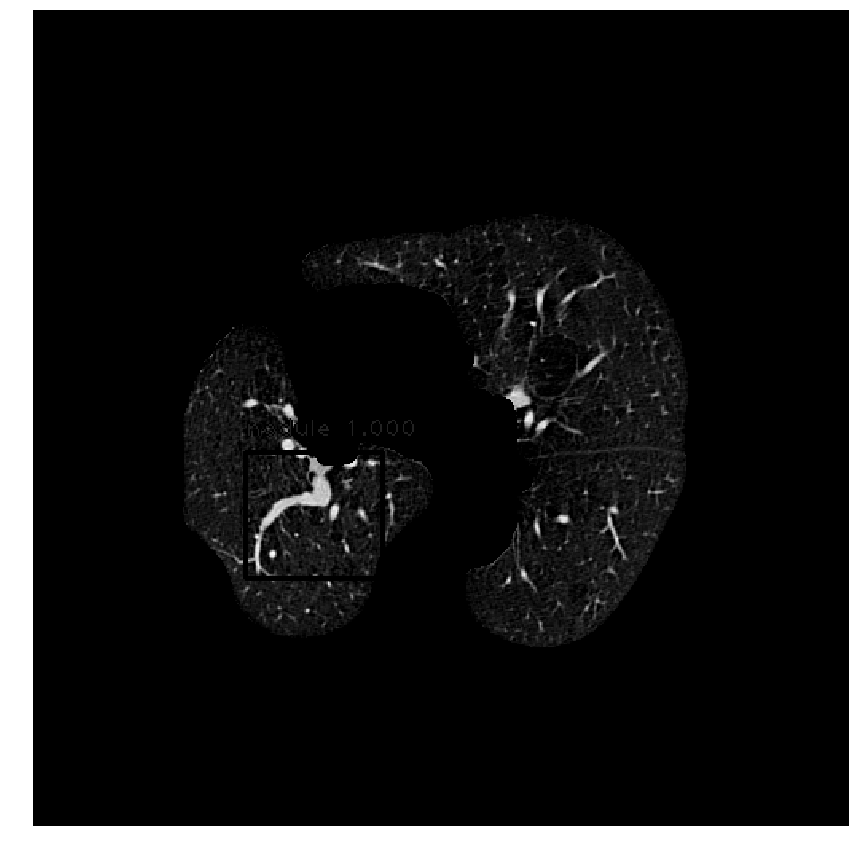

145


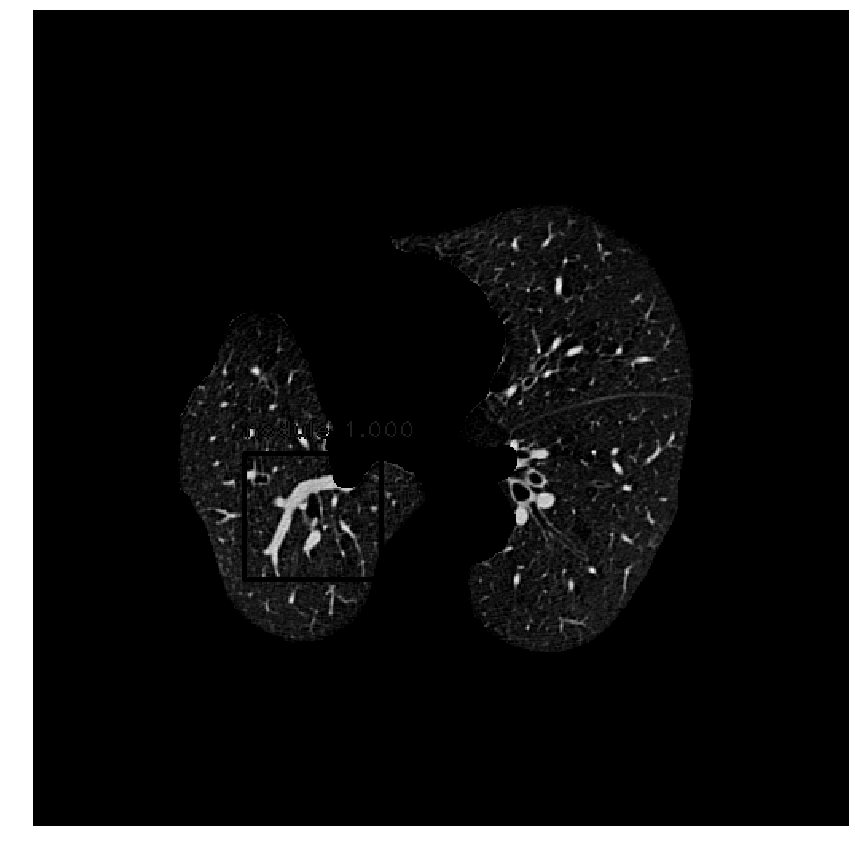

135


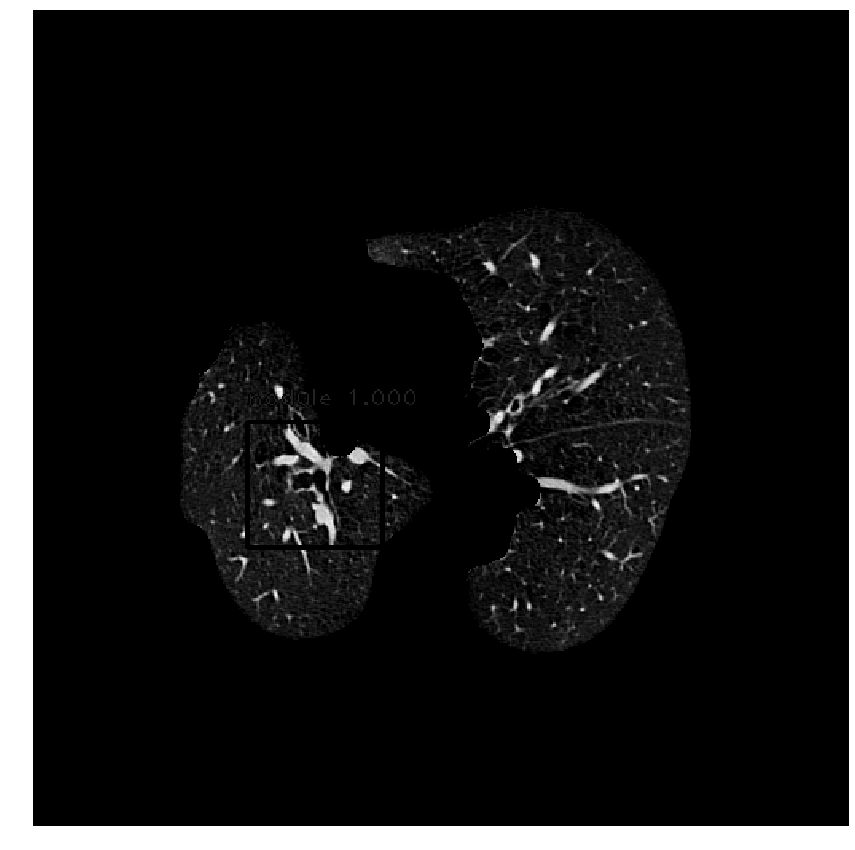

126


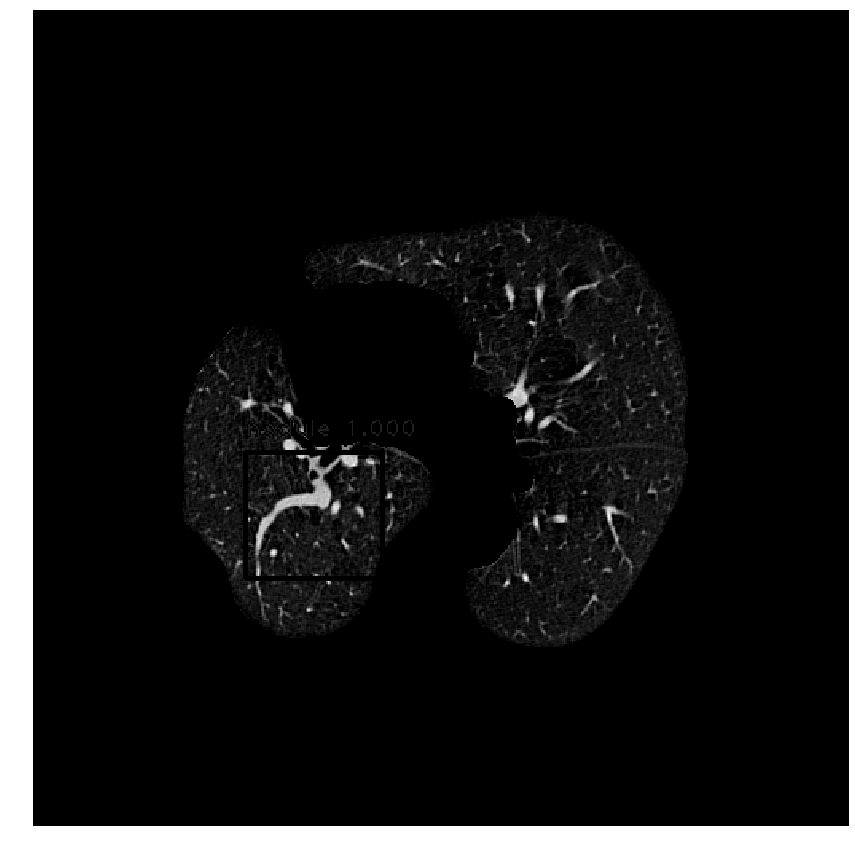

136


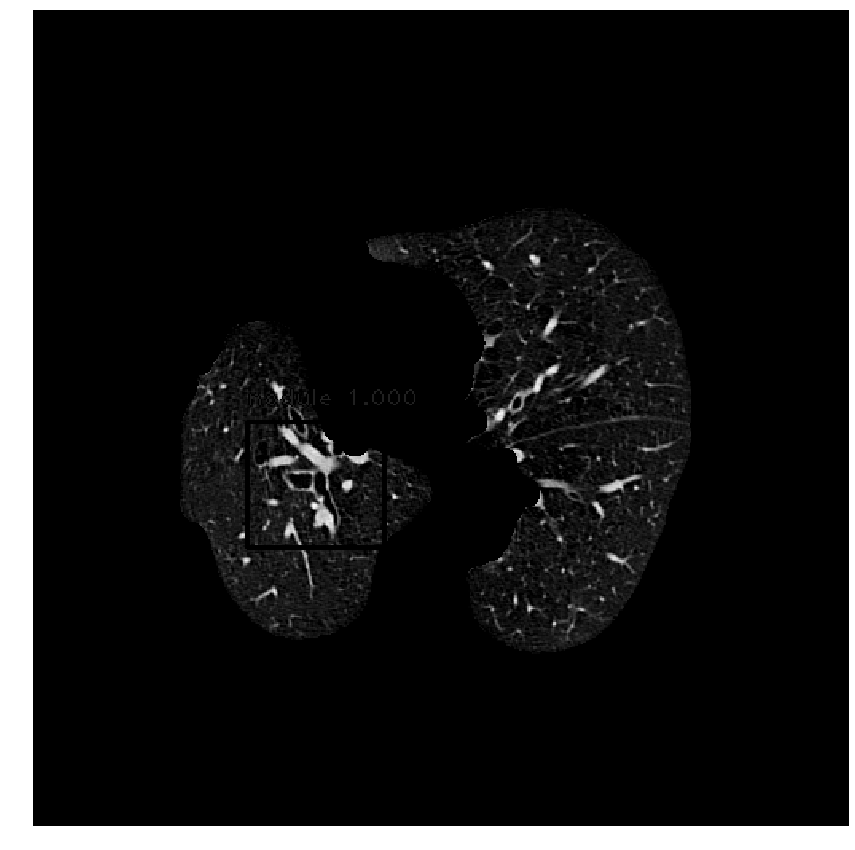

144


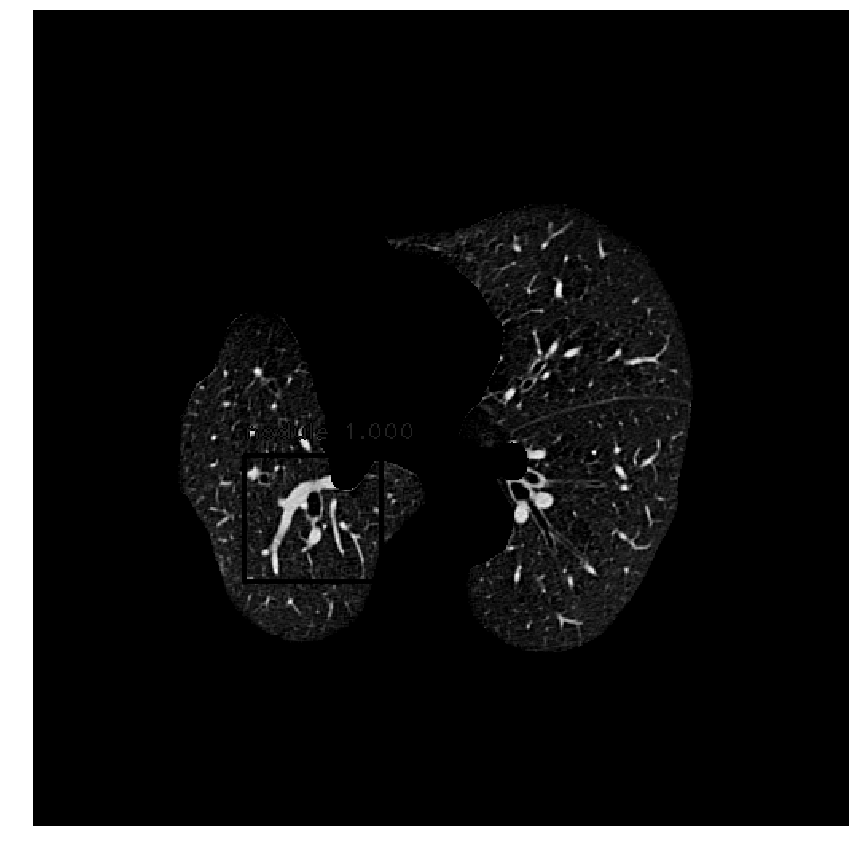

137


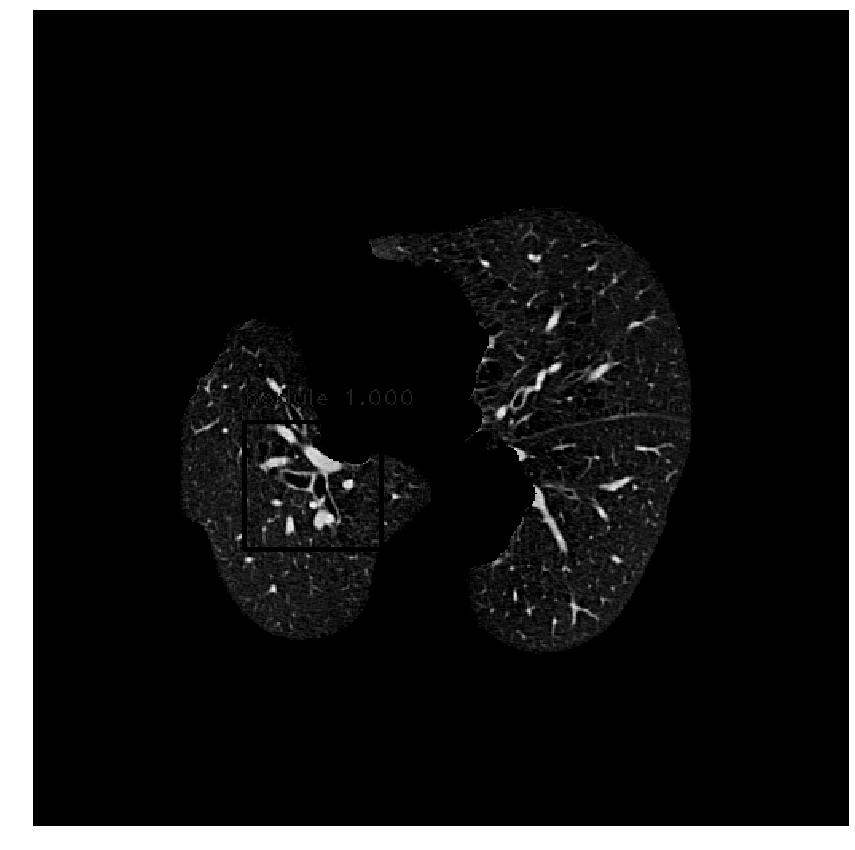

127


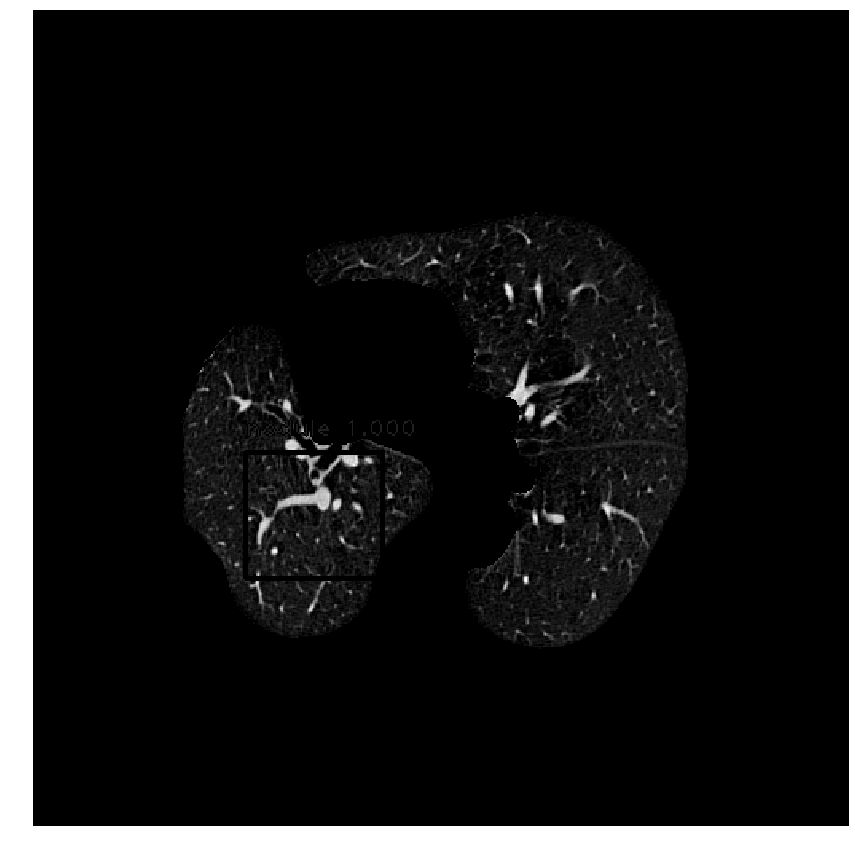

146


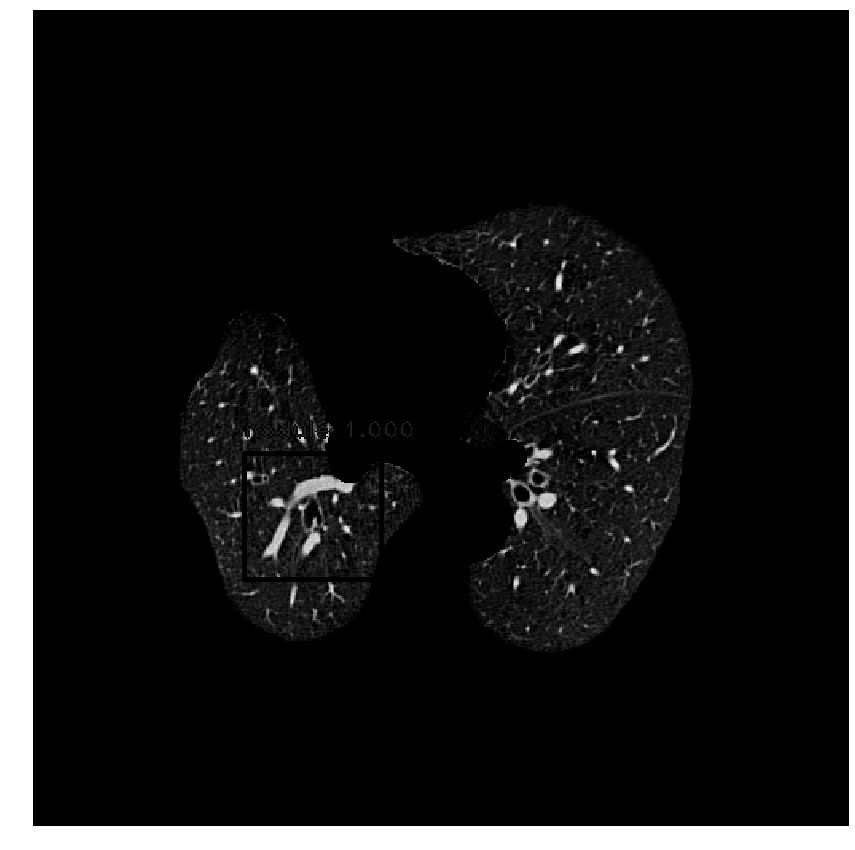

134


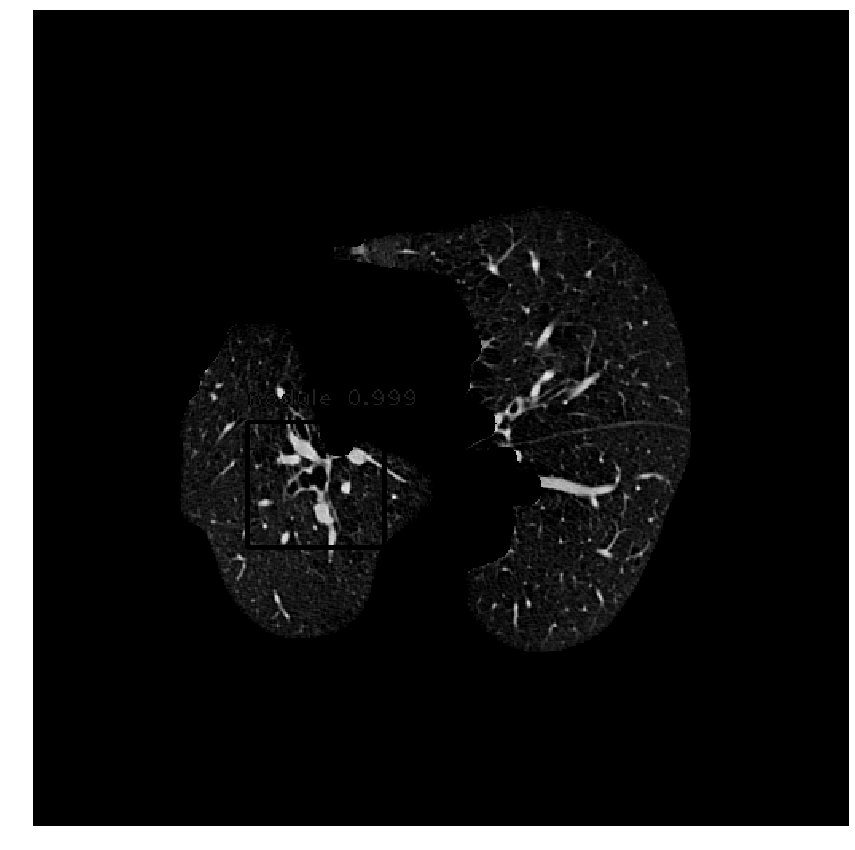

153


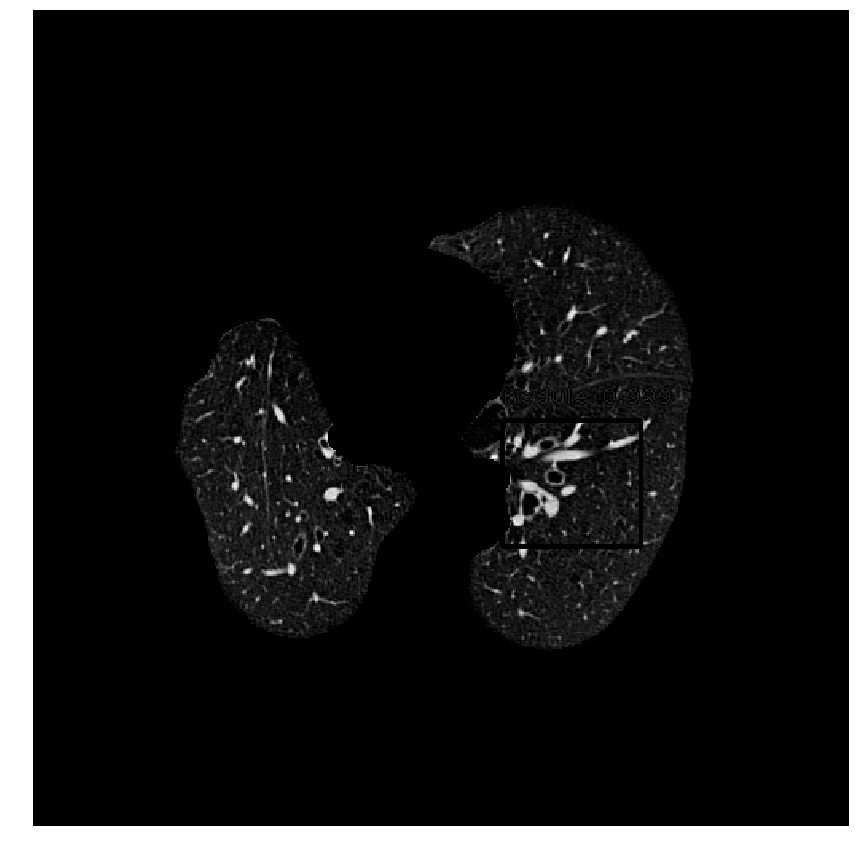

151


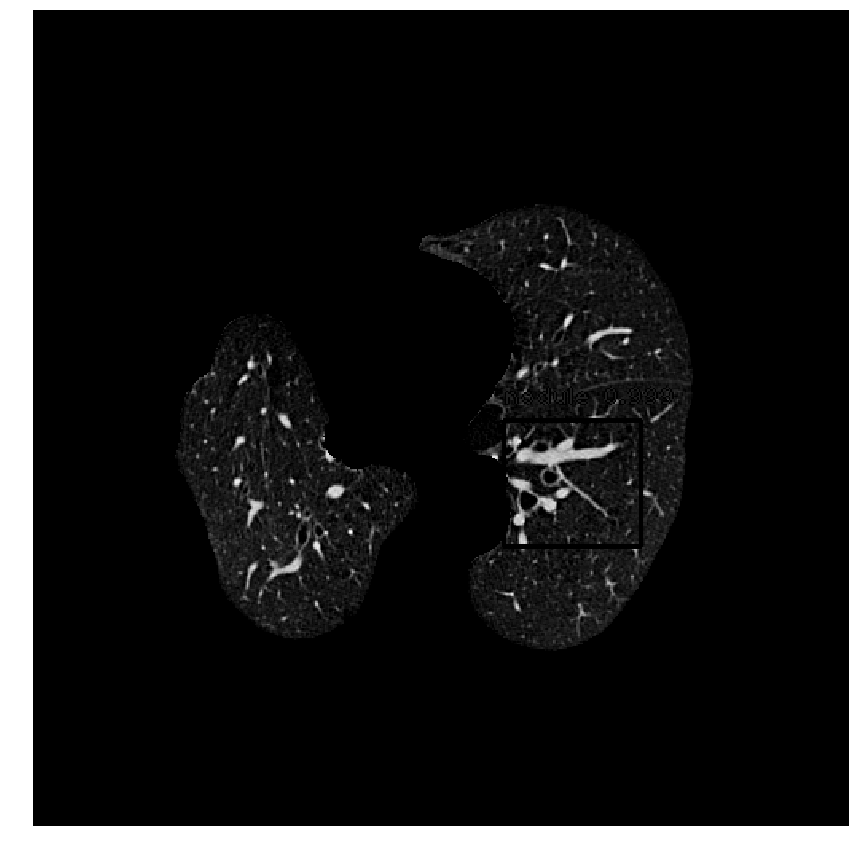

154


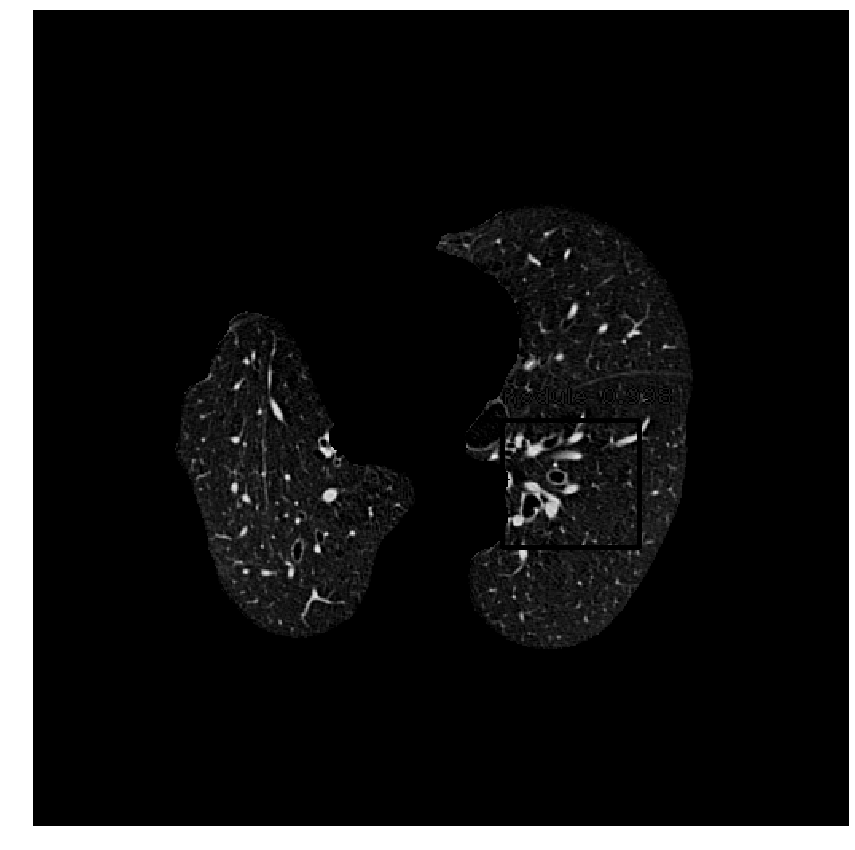

143


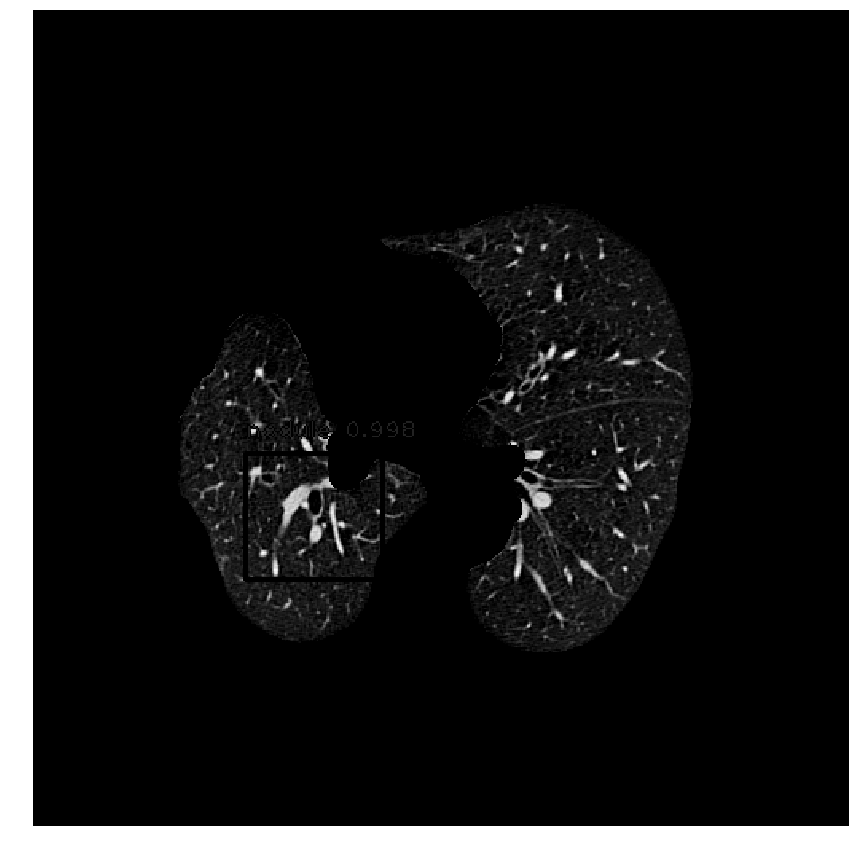

152


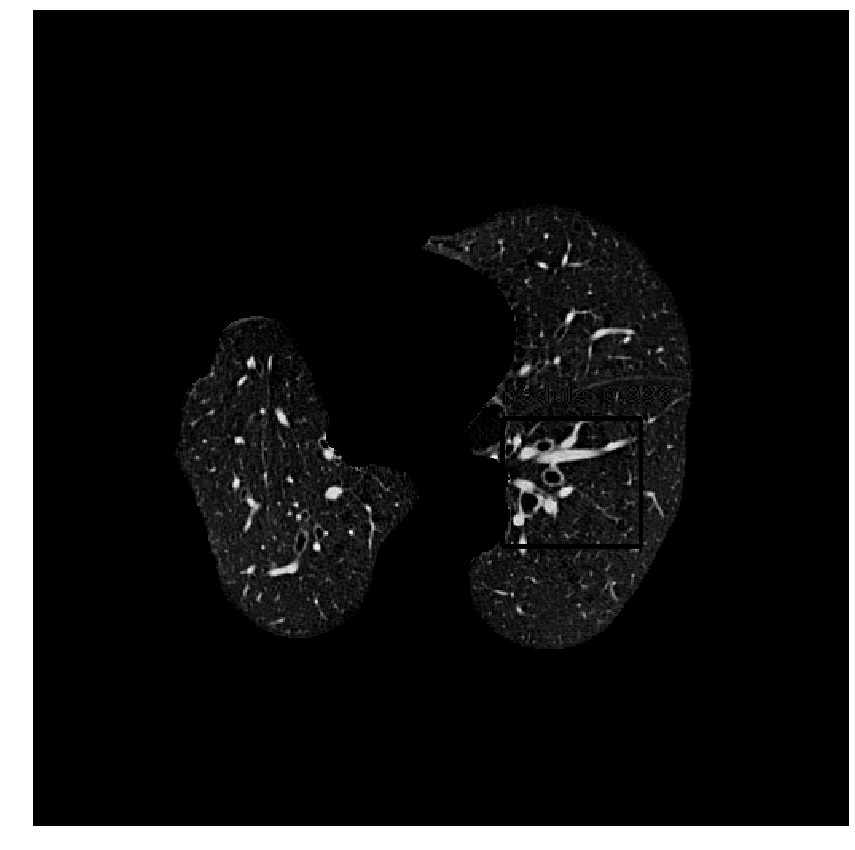

138


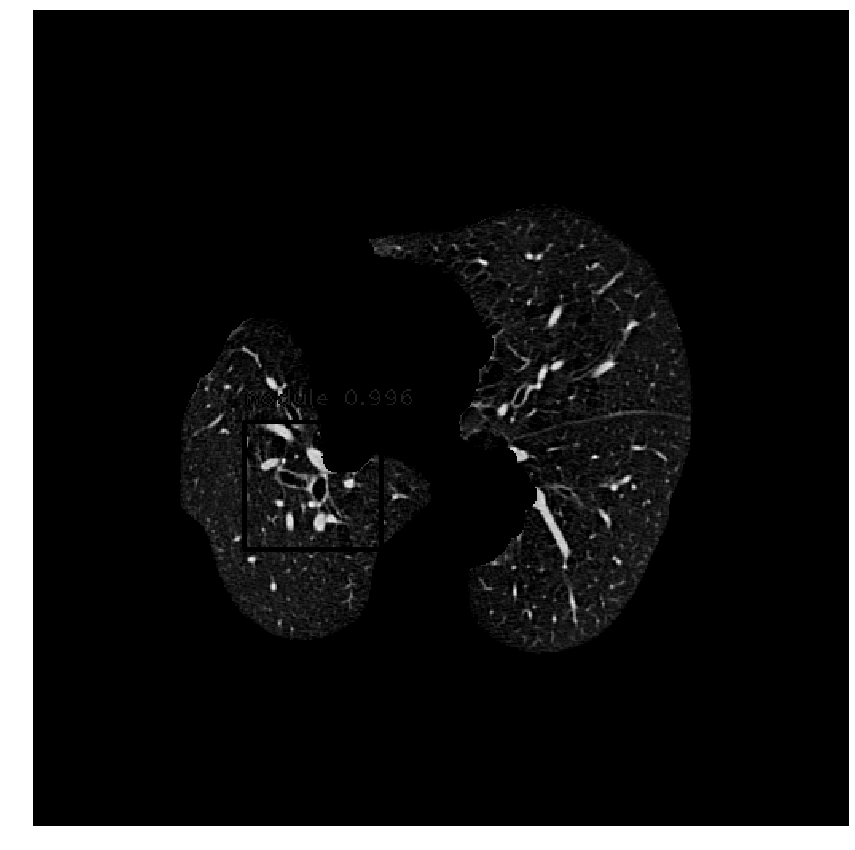

In [ ]:
#ct_scan
for  box, label,n,score in sorted_z:
    
    image = ct_scan[n]
    print(n)
    # copy to draw on
    draw = image.copy()
    #draw = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # preprocess image for network
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image_color = preprocess_image(image_color)
    image_color, scale = resize_image(image_color)
        
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw,cmap='gray' )
    plt.show()

In [ ]:
selem = ball(2)
binary = binary_closing(segmented_ct_scan, selem)

label_scan = label(binary)

areas = [r.area for r in regionprops(label_scan)]
areas.sort()

for r in regionprops(label_scan):
    max_x, max_y, max_z = 0, 0, 0
    min_x, min_y, min_z = 1000, 1000, 1000
    
    for c in r.coords:
        max_z = max(c[0], max_z)
        max_y = max(c[1], max_y)
        max_x = max(c[2], max_x)
        
        min_z = min(c[0], min_z)
        min_y = min(c[1], min_y)
        min_x = min(c[2], min_x)
    if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
        for c in r.coords:
                        segmented_ct_scan[c[0], c[1], c[2]] = 0
    else:
        index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))

In [ ]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = mcubes.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(25, 25))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    

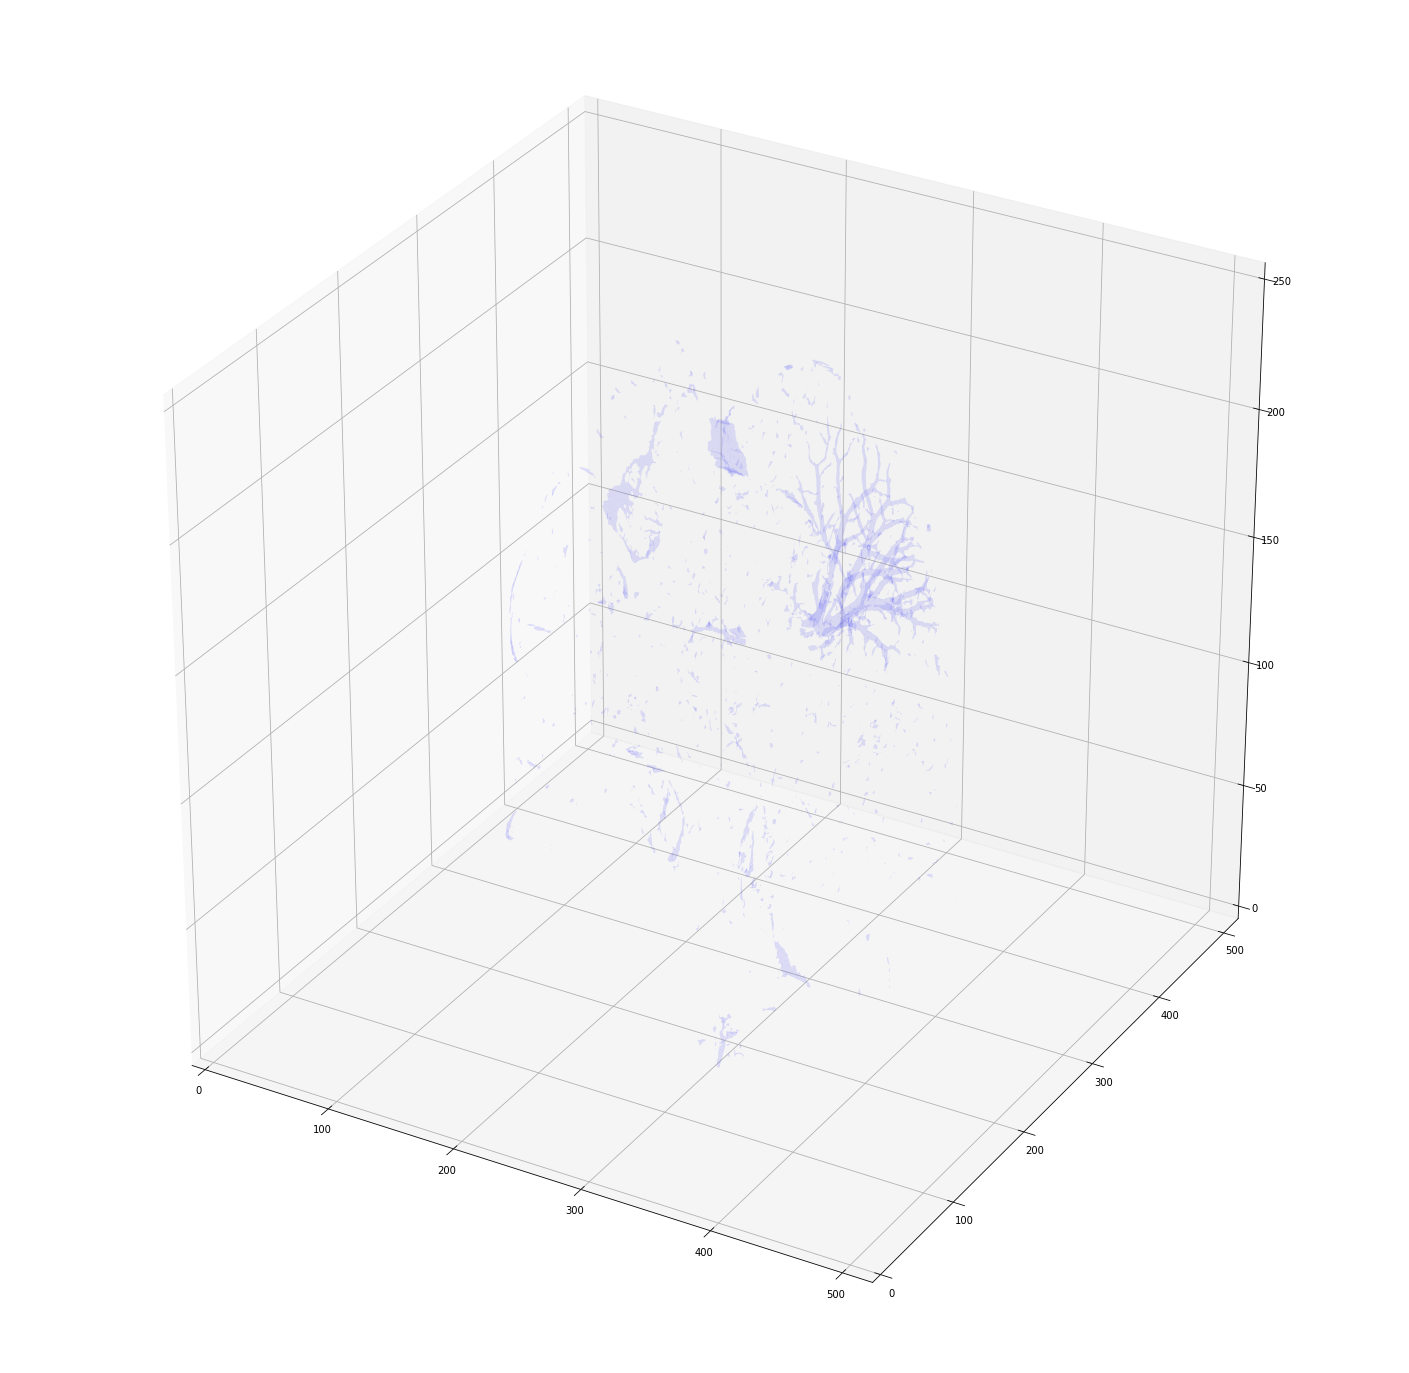

In [ ]:
plot_3d(segmented_ct_scan,604)

In [ ]:
import ipyvolume as ipv
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
pot = segmented_ct_scan
binary = pot

import ipyvolume as ipv
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

#fig = ipv.figure(render_continuous=True)
fig = ipv.figure()
#change in 3rd order

#V = np.zeros((512,512,512))
#V[50:-50,50:-50,254:-254] = 0.25
#ipv.pylab.volshow(V, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)

ipv.plot_isosurface(segmented_ct_scan, extent=[[0,512], [0,512], [0, 512]],controls=False)
x,y,z = np.random.normal(206,210,(3,10))
ipv.scatter(x,y,z,color='green',size=2,marker='sphere')
ipv.pylab.style.axes_on()
ipv.show()
ipv.embed.embed_html('/notebooks/MY_VOLUME/keras-retinanet-0.5.0/keras-retinanet-0.5.0/test.html', fig)

In [ ]:
pot = segmented_ct_scan
binary = pot

In [ ]:
fig = ipv.figure(width=512, height=512,render_continuous=True)
V = np.zeros((512,512,512))

#test_loop_later
V[133:-292,277:-155,243:-257] = 0.25
#ipv.pylab.volshow(V, level=[0.25, 0.75], opacity=0.1, level_width=0.1, data_min=0, data_max=1)
#V[133:-293,277:-146,150:-290] = 0.25
ipv.pylab.volshow(V, level=[0.25, 0.75], opacity=0.1, level_width=0.1, data_min=0, data_max=1)
ipv.plot_isosurface(binary, extent=[[0,512], [0,512], [0, 512]])
#x,y,z,vx,vy,vz = np.random.normal(210,212,(6,10))
#ipv.quiver(x, y, z,vx,vy,vz , size=10,color='blue')
ipv.show()
#ipv.embed.embed_html('/notebooks/MY_VOLUME/keras-retinanet-0.5.0/keras-retinanet-0.5.0/test.html', fig)

Test loop several box

In [ ]:
z = zip(boxess,labelss,namess,scoress )
sorted_z = sorted(z, key=lambda x: x[3], reverse = True)
print(sorted_z)

[(array([133.20354, 277.1851 , 219.19943, 356.5902 ], dtype=float32), 1, 125, 0.9999541), (array([132.13065, 278.6028 , 218.9079 , 357.67282], dtype=float32), 1, 145, 0.99994516), (array([134.03168, 258.26175, 219.89365, 337.4432 ], dtype=float32), 1, 135, 0.9999386), (array([133.44824, 277.32498, 219.6374 , 356.87042], dtype=float32), 1, 126, 0.99992645), (array([134.73639, 258.6054 , 220.60631, 337.71716], dtype=float32), 1, 136, 0.9998977), (array([132.61452, 279.03958, 218.47734, 358.02484], dtype=float32), 1, 144, 0.9997706), (array([132.93027, 258.6395 , 218.26341, 338.01065], dtype=float32), 1, 137, 0.9997601), (array([133.68484, 277.24402, 219.30135, 356.8524 ], dtype=float32), 1, 127, 0.99965346), (array([132.24117, 278.409  , 218.93288, 357.62207], dtype=float32), 1, 146, 0.9995598), (array([134.21439, 258.47452, 220.00616, 337.80383], dtype=float32), 1, 134, 0.99932516), (array([294.69748, 257.50867, 381.04385, 336.90753], dtype=float32), 1, 153, 0.99927896), (array([295.078

In [ ]:
print(sorted_z[0][0][2])

219.19943


In [ ]:
bb = 512 - sorted_z[0][0][2]
bb = bb*-1
print(bb)

-292.8005676269531


In [ ]:
print(sorted_z[0][2])

125


In [ ]:
mn = sorted_z[0][2]-2
mx = -1*(512-(sorted_z[0][2]+2))
print(mn)
print(mx)

123
-385
